# YOLOv8 + Roboflow Colab Notebook

*Generated on 2025-09-06 16:55:08 UTC*

This notebook walks through **step-by-step** how to download a dataset from Roboflow and train a YOLOv8 model on Google Colab.

**Important:** Set **Runtime > Change runtime type > Hardware accelerator > GPU** (e.g. `T4`).

Keep your Roboflow API key private. Replace the example API key in the cell below with your own.

---



## 0) Quick GPU check (run this first)

In [ ]:
# Run this cell to check GPU availability in Colab
import torch, sys
print("Python:", sys.version.splitlines()[0])
print("Torch version:", getattr(torch, '__version__', 'not installed'))
try:
    import subprocess, shlex
    print("CUDA available:", torch.cuda.is_available())
    !nvidia-smi
except Exception as e:
    print("nvidia-smi not available or error:", e)

Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Torch version: 2.8.0+cu126
CUDA available: False
/bin/bash: line 1: nvidia-smi: command not found


## 1) Install required libraries
This installs the official `ultralytics` package (YOLOv8) and `roboflow` to download your dataset programmatically.

In [ ]:
print("Installing dependencies... This may take ~1-2 minutes")
# Install packages (will run in Colab)
!pip install -q ultralytics roboflow
# Optional: show installed versions
import importlib, pkgutil
for pkg in ('ultralytics','roboflow'):
    mod = importlib.import_module(pkg)
    print(pkg, getattr(mod, '__version__', 'version unknown'))

Installing dependencies... This may take ~1-2 minutes
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 107.9 MB/s eta 0:00:00
ultralytics 8.3.195
roboflow 1.2.7


## 2) (Optional) Mount Google Drive to save models
Mount Drive if you want model weights automatically saved to your Drive. Otherwise weights will be saved to `/content/runs`.

In [ ]:
# If you want to save models to Google Drive, uncomment and run this cell
try:
    from google.colab import drive
    print("To mount your Google Drive, run:")
    print("drive.mount('/content/drive')")
except Exception as e:
    print("Running outside Google Colab or google.colab is not available.")

To mount your Google Drive, run:
drive.mount('/content/drive')


## 3) Download dataset from Roboflow
Fill in your Roboflow API key and project details in the cell below. **Do not share your API key publicly.**

In [ ]:
# ----- EDIT THESE VARIABLES -----
API_KEY = "P426k2kpJwIxkYX7mHm7"  # <-- Replace with your Roboflow API key if you want to keep it private
WORKSPACE = "jidnesh"             # <-- Your Roboflow workspace name
PROJECT = "graff-ymab0-0auui"     # <-- Your Roboflow project id (slug)
VERSION = 1                       # <-- Project version number
FORMAT = "yolov8"                 # <-- Download format, leave as 'yolov8'

# ----- DO NOT EDIT BELOW (unless you know what you are doing) -----
print('Downloading dataset from Roboflow...')
from roboflow import Roboflow
import os, textwrap, sys, glob

try:
    rf = Roboflow(api_key=API_KEY)
    proj = rf.workspace(WORKSPACE).project(PROJECT)
    dataset = proj.version(VERSION).download(FORMAT)
    print("Download complete. Dataset location:", dataset.location)
    # Show a quick listing
    print("\nSample files in dataset folder:")
    for p in glob.glob(os.path.join(dataset.location, '*'))[:20]:
        print(" -", p)
except Exception as e:
    print("Error downloading dataset. If you're in Colab make sure the API_KEY, WORKSPACE and PROJECT are correct and that the session has internet access.")
    print("Exception:", e)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Graff-1 in yolov8:: 100%|██████████| 2126/2126 [00:02<00:00, 743.21it/s] 

Download complete. Dataset location: /content/Graff-1

Sample files in dataset folder:
 - /content/Graff-1/train
 - /content/Graff-1/test
 - /content/Graff-1/README.roboflow.txt
 - /content/Graff-1/valid
 - /content/Graff-1/README.dataset.txt
 - /content/Graff-1/data.yaml


## 4) Inspect dataset and show sample images
This cell prints `data.yaml` contents and displays a couple of sample images with their corresponding labels.

Data YAML path: /content/Graff-1/data.yaml

--- data.yaml ---

names:
- Graffiti
nc: 1
roboflow:
  license: CC BY 4.0
  project: graff-ymab0-0auui
  url: https://universe.roboflow.com/jidnesh/graff-ymab0-0auui/dataset/1
  version: 1
  workspace: jidnesh
test: ../test/images
train: ../train/images
val: ../valid/images



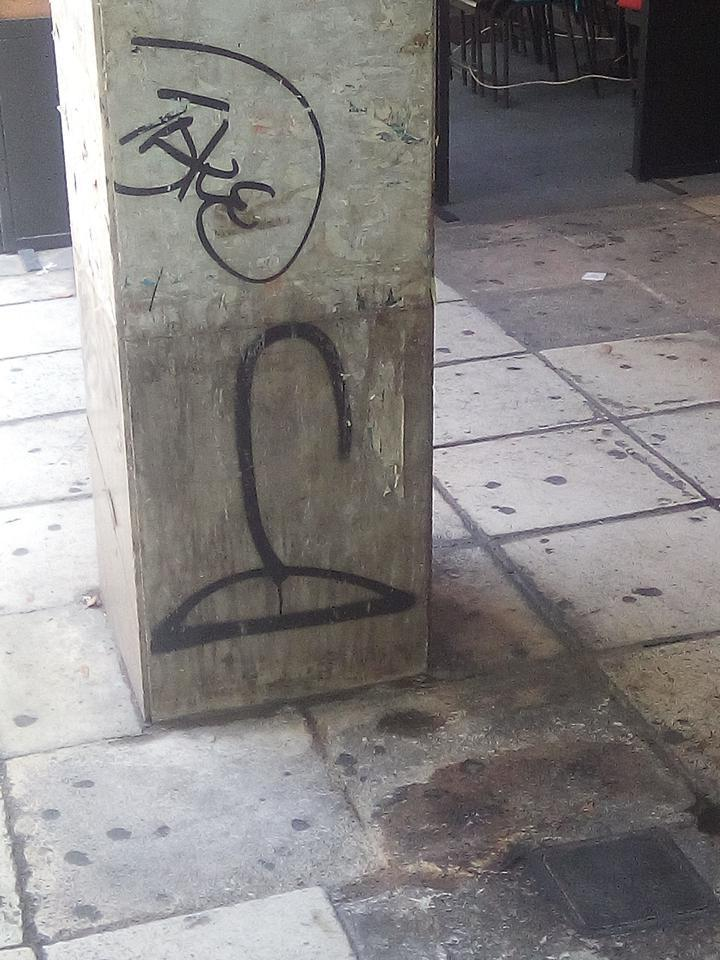

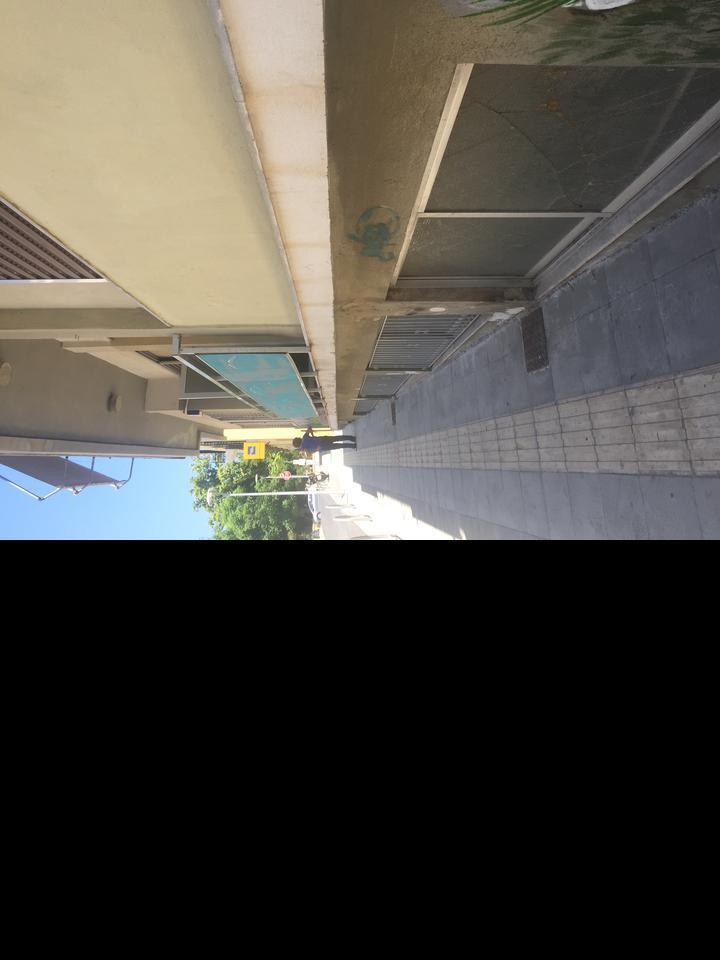

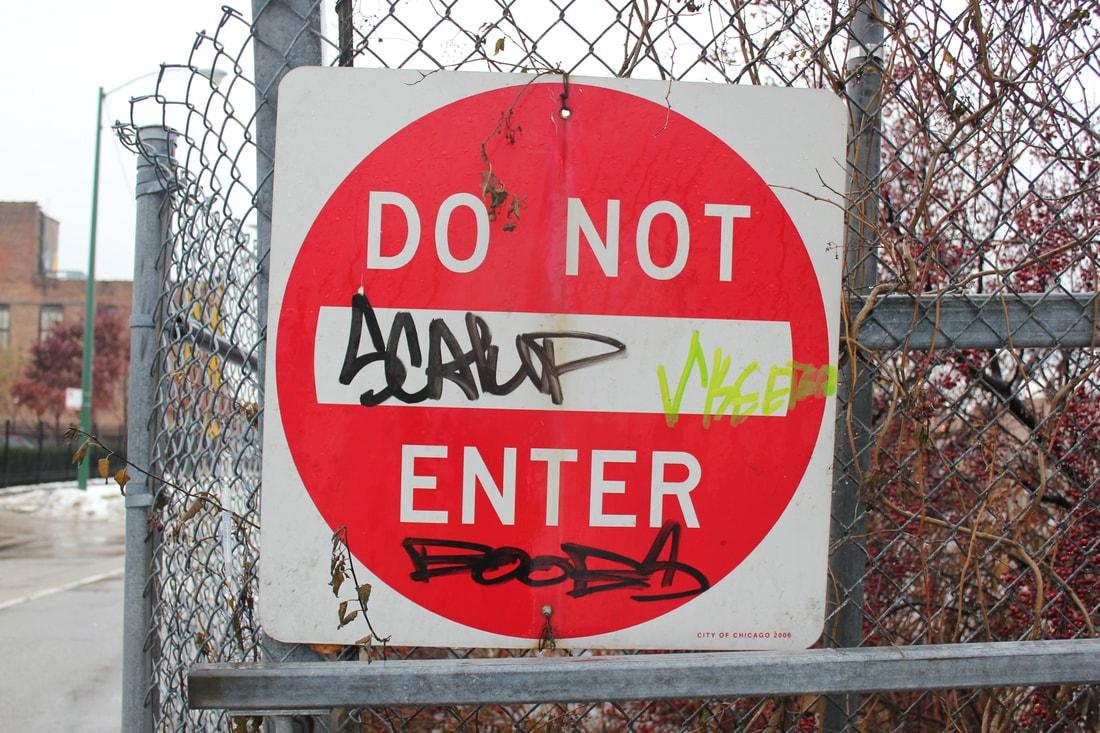

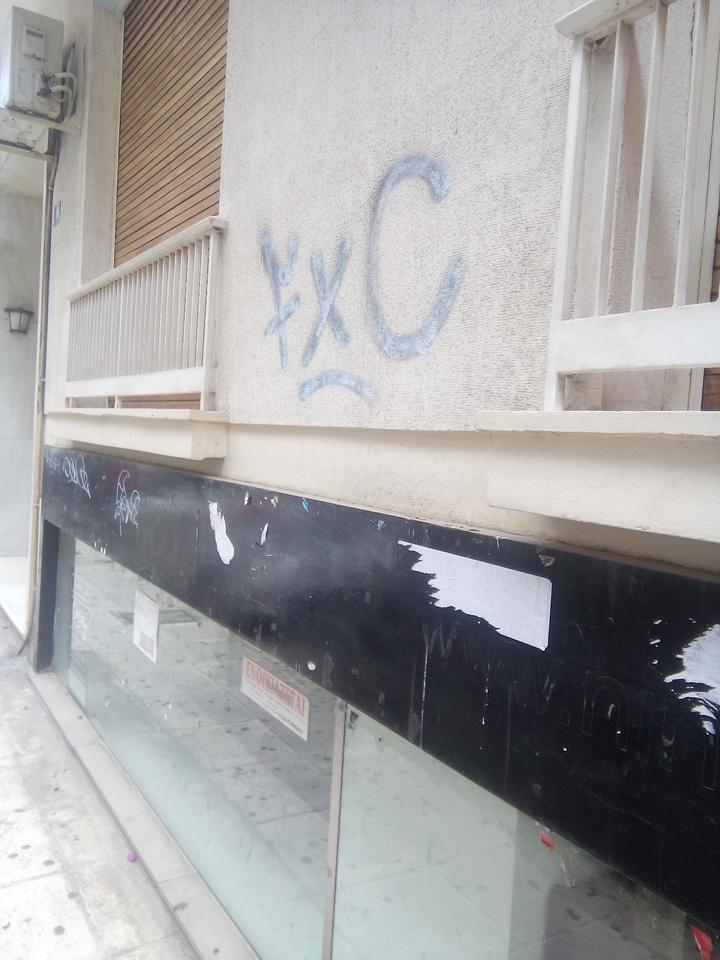

In [ ]:
import os, glob, yaml, random, IPython.display as display
try:
    data_yaml = os.path.join(dataset.location, "data.yaml")
    print("Data YAML path:", data_yaml)
    with open(data_yaml, 'r') as f:
        print("\n--- data.yaml ---\n")
        print(f.read())
except Exception as e:
    print("Could not open data.yaml:", e)

# Display up to 4 sample images from the dataset's train folder
try:
    train_img_dir = os.path.join(dataset.location, 'data', 'images', 'train')
    if not os.path.exists(train_img_dir):
        # Roboflow sometimes places images differently depending on format version
        train_img_dir = os.path.join(dataset.location, 'train', 'images')
    imgs = glob.glob(os.path.join(train_img_dir, '*.jpg')) + glob.glob(os.path.join(train_img_dir, '*.png'))
    if len(imgs)==0:
        print("No sample images found in", train_img_dir)
    else:
        sample = random.sample(imgs, min(4, len(imgs)))
        for img in sample:
            display.display(display.Image(filename=img, width=420))
except Exception as e:
    print('Error showing sample images:', e)

## 5) Train YOLOv8
This cell trains a YOLOv8n model (nano). **Adjust `epochs` and `imgsz` to suit your use-case**. If you mounted Drive earlier you can set `project` to save runs there.

In [ ]:
# Training settings - edit as needed
EPOCHS = 25
IMGSZ = 640
BATCH = 16  # optional; ultralytics will auto-adjust if GPU memory is low
PROJECT_DIR = '/content/runs'  # change to '/content/drive/MyDrive/your-folder' to save to Drive
RUN_NAME = 'graff_train_run'

from ultralytics import YOLO
import os, glob, warnings

# Load pretrained YOLOv8n weights (small and fast)
print("Loading model...")
model = YOLO('yolov8n.pt')  # if this file isn't present it will be downloaded automatically by ultralytics

print("Starting training: epochs=", EPOCHS)
try:
    results = model.train(data=os.path.join(dataset.location, "data.yaml"),
                          epochs=EPOCHS,
                          imgsz=IMGSZ,
                          batch=BATCH,
                          project=PROJECT_DIR,
                          name=RUN_NAME)
    print("Training finished. Results object:", type(results))
except Exception as e:
    print("Training failed or was interrupted:", e)
    warnings.warn("If you are running this outside Colab or without internet access, ultralytics may not be able to download the model weights or datasets.")

Loading model...
Starting training: epochs= 25
Ultralytics 8.3.195 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Graff-1/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=graff_train_run, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patienc

## 6) Evaluate & locate best weights
After training, the best weights are usually saved to `runs/train/<run_name>/weights/best.pt`. This cell runs validation and prints the path.

In [ ]:
# Evaluate on validation set
try:
    print("Running validation... (this may run quickly or take a while depending on dataset size)")
    val_metrics = model.val()
    print("\nValidation metrics object:", val_metrics)
except Exception as e:
    print("Validation could not be completed:", e)

# Find best.pt in runs folder
import glob, os
candidates = glob.glob(os.path.join(PROJECT_DIR, 'train', RUN_NAME, 'weights', 'best*.pt')) + glob.glob('/content/runs/train/*/weights/best*.pt')
candidates = sorted(set(candidates))
if candidates:
    print("\nFound best weights at:")
    for c in candidates:
        print(" -", c)
else:
    print("\nNo best weights found yet. Check /content/runs or the output logs to see where weights were saved.")

Running validation... (this may run quickly or take a while depending on dataset size)
Ultralytics 8.3.195 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 599.5±220.0 MB/s, size: 101.0 KB)
val: Scanning /content/Graff-1/valid/labels.cache... 147 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 147/147 189.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 10/10 0.3it/s 29.3s
                   all        147        353      0.822      0.618      0.706      0.485
Speed: 1.9ms preprocess, 182.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /content/runs/graff_train_run2

Validation metrics object: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/runs/graff_train_run/weights/best.pt /content/drive/MyDrive/best.pt
!cp /content/runs/graff_train_run/weights/last.pt /content/drive/MyDrive/last.pt



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 7) (Optional) Copy trained weights to Google Drive
Uncomment and run to copy saved weights into your Drive if you mounted it earlier.

In [ ]:
# Example: copy best.pt to your Drive (uncomment and edit paths if you mounted Drive)
# from google.colab import drive
# drive.mount('/content/drive')
# src = '/content/runs/train/graff_train_run/weights/best.pt'
# dst = '/content/drive/MyDrive/yolov8_weights/graff_best.pt'
# import shutil, os
# os.makedirs(os.path.dirname(dst), exist_ok=True)
# shutil.copy2(src, dst)
# print("Copied best.pt to Drive:", dst)

## Tips & Troubleshooting
- If training errors say out-of-memory, reduce `IMGSZ` or `BATCH` or use a smaller model (e.g., `yolov8n.pt` is already the smallest).
- If Roboflow download fails: double-check `API_KEY`, `WORKSPACE` and `PROJECT` values and make sure the Colab session has internet.
- To resume training from a checkpoint, pass `resume=True` or `model.train(..., resume=True)` and point to the checkpoint.
- To export to ONNX/TensorRT or use different model sizes, see `ultralytics` docs: `from ultralytics import YOLO; model.export(format='onnx')`.

In [ ]:
from google.colab import files
from ultralytics import YOLO
import shutil, glob
from IPython.display import Video

# 1. Upload your video
uploaded = files.upload()
video_path = list(uploaded.keys())[0]  # get uploaded file name

# 2. Load trained model (update path to your best.pt)
model = YOLO("/content/runs/graff_train_run/weights/best.pt")

# 3. Run inference (save results in a clean folder name)
results = model.predict(source=video_path, save=True, conf=0.25, name="predict_clean")

# 4. Find the most recent prediction folder
pred_folder = sorted(glob.glob("runs/detect/predict_clean*"))[-1]

# 5. Find the saved video inside prediction folder
pred_videos = glob.glob(f"{pred_folder}/*.mp4")
output_path = "output.mp4"

# 6. Move the first predicted video and display it
if pred_videos:
    shutil.move(pred_videos[0], output_path)
    display(Video(output_path, embed=True, width=640, height=480))
else:
    print("No predicted video found!")


Saving Fast GRAFFITI piece on abandoned building spray paint throw up #graffiti #tagging #spray.mp4 to Fast GRAFFITI piece on abandoned building spray paint throw up #graffiti #tagging #spray (3).mp4

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/357) /content/Fast GRAFFITI piece on abandoned building spray paint throw up #graffiti #tagging #spray (3).mp4: 640x384 2 Graffitis, 208.9ms
video 1/1 (frame 2/357) /content/Fast GRAFFITI piece on abandoned building spray paint throw up 